# Detecting communities in graphs

In this notebook we will present the method we used to partition an input graph into sub-graphs, with each sub-graph representing a community. This task is (almost) identical to graph clustering, which we have seen in class. We will begin by presenting a simple example that will illustrate the adopted framework, then we will use said framework to detect the communities in a real-world graph.

Let's first load the necessary modules, perform some set-up and define a few functions that will be useful later.

In [1]:
#import the necessary libraries:
import networkx as nx
from networkx.algorithms import community as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import math
import copy

#proper formatting:
%matplotlib inline

#set-up:
seed = 1
np.random.seed(seed)
warnings.filterwarnings('ignore')

#useful functions (no need to look into them):

#function to draw the dendrogram associated with the communities found by the Girvan-Newman algorithm
#CREDIT: https://stackoverflow.com/questions/59821151/plot-the-dendrogram-of-communities-found-by-networkx-girvan-newman-algorithm
def draw_dendogram_girvan_newman_communities(communities):
    import networkx as nx
    from itertools import chain, combinations
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram
    communities = list(communities)
    node_id = 0
    init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
    for comm in communities:
        for subset in list(comm):
            if subset not in init_node2community_dict.values():
                node_id += 1
                init_node2community_dict[node_id] = subset
    node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
    for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
        for node_id_parent, group in init_node2community_dict.items():
            if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
                node_id_to_children[node_id_parent].append(node_id1)
                node_id_to_children[node_id_parent].append(node_id2)
    node_labels = dict()
    for node_id, group in init_node2community_dict.items():
        if len(group) == 1:
            node_labels[node_id] = list(group)[0]
        else:
            node_labels[node_id] = ''
    subset_rank_dict = dict()
    rank = 0
    for e in communities[::-1]:
        for p in list(e):
            if tuple(p) not in subset_rank_dict:
                subset_rank_dict[tuple(sorted(p))] = rank
                rank += 1
    subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank
    def get_merge_height(sub):
        sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
        n = len(sub_tuple)
        other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
        min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
        range = (max_rank-min_rank) if max_rank > min_rank else 1
        return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range
    G           = nx.DiGraph(node_id_to_children)
    nodes       = G.nodes()
    leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
    inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]
    subtree = dict( (n, [n]) for n in leaves )
    for u in inner_nodes:
        children = set()
        node_list = list(node_id_to_children[u])
        while len(node_list) > 0:
            v = node_list.pop(0)
            children.add( v )
            node_list += node_id_to_children[v]
        subtree[u] = sorted(children & leaves)
    inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last
    leaves = sorted(leaves)
    index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
    Z = []
    k = len(leaves)
    for i, n in enumerate(inner_nodes):
        children = node_id_to_children[n]
        x = children[0]
        for y in children[1:]:
            z = tuple(sorted(subtree[x] + subtree[y]))
            i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
            Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
            index[z] = k
            subtree[z] = list(z)
            x = z
            k += 1
    plt.figure()
    dn = dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])

#reads the .csv files containing the node and edge sets of a graph; returns the graph
def import_graph(node_filename, edge_filename):
    #read the datasets
    node_set = pd.read_csv(node_filename, sep = ',')
    edge_set = pd.read_csv(edge_filename, sep = ',')

    #remove the nodes with missing lable (NaN)
    node_set.replace('', np.nan, inplace=True)
    node_set = node_set.dropna()

    #print the datasets
    #print(node_set)
    #print(edge_set)

    #extract the values from the node/edge sets
    edges = edge_set.values
    nodes = node_set.values

    #empty graph that will be populated with the nodes/edges
    graph = nx.Graph()

    #add nodes to the graph
    for i in range(len(nodes)):
        graph.add_node(nodes[i][2], name = nodes[i][1])

        #check the added nodes
        #print("Added node " + str(nodes[i][2]) + " with name " + str(nodes[i][1]))

    #add edges to the graph
    for i in range(len(edges)):
        #check if the end-nodes are in the graph
        if edges[i][0] in graph and edges[i][1] in graph:
            graph.add_edge(edges[i][0], edges[i][1])

            #check the added edges
            #print("Added edge (" + str(edges[i][0]) + ", " + str(edges[i][1]) + ")")

        #else:
            #check the rejected edges
            #print("Edge (" + str(edges[i][0]) + ", " + str(edges[i][1]) + ") has at least one non labled end-node")

    #draw the graph
    #nx.draw(graph, with_labels=True, font_weight='bold')
    
    return graph
    
#print the communities and draw the associated subgraphs
def report_communities(graph, communities):
    #unfreeze the communities
    communities = list([list(x) for x in communities])
    
    #the subgraph of each community
    subgraphs = list()
    for i in range(len(communities)):
        subgraphs.append(nx.subgraph(graph, communities[i]))
        plt.subplot(1, len(communities), i+1)
        nx.draw(subgraphs[i], with_labels=True, font_weight='bold')
        print("\nCommunity " + str(i) + ", nodes: " + str(communities[i]) + ", labels: ")
        for j in range(len(communities[i])):
            print("-" + str(graph.nodes[communities[i][j]]['name']))

#removes the outliers (low degree nodes) from the graph
def clean_up(graph, alpha):
    #unfreeze the graph if frozen
    if nx.is_frozen(graph):
        graph = nx.Graph(graph)
    
    #degree histogram
    deg_hist = nx.degree_histogram(graph)
    
    #uncomment to plot the histogram
    #plt.bar(range(0, len(deg_hist)), deg_hist)
    #plt.ylabel('Frequency')
    #plt.xlabel('Degree');

    #compute the average degree of a node
    num_nodes = 0
    avg_deg = 0
    for i in range(len(deg_hist)):
        num_nodes += deg_hist[i]
        avg_deg += i*deg_hist[i]
    avg_deg /= num_nodes
    #print("Average node degree: " + str(avg_deg))

    #compute the degree threshold at which nodes will be maintained in the graph
    degree_threshold = 0
    num_nodes2remove = math.floor(alpha*nx.number_of_nodes(graph))
    num_nodes_removed = 0
    while num_nodes_removed + deg_hist[degree_threshold] <= num_nodes2remove:
        num_nodes_removed += deg_hist[degree_threshold]
        degree_threshold += 1
    #print("Degree threshold (nodes below this threshold will be removed): " + str(degree_threshold))
    #print(str(num_nodes_removed) + " nodes will be removed, ideally " + str(num_nodes2remove) + " nodes would be removed")

    #remove the nodes that have degree below the threshold from the graph
    for node in list(nx.nodes(graph)):
        if nx.degree(graph, node) < degree_threshold:
            #check the removed node
            #print("Removed: " + str(graph.nodes[node]['name']))
            graph.remove_node(node)

    #plot the resulting graph
    #nx.draw(graph, with_labels=True, font_weight='bold')
    
    return graph
    
#detects and returns communities
def detect_communities(graph):
    #unfreeze the graph if frozen
    if nx.is_frozen(graph):
        graph = nx.Graph(graph)
    
    #detect communities based on greedy modularity
    gm_communities = ct.greedy_modularity_communities(graph)
    
    #unfreeze the communities
    gm_communities = list([list(x) for x in gm_communities])

    #number of detected communities
    num_communities = len(gm_communities)
    print("Number of detected communities: " + str(num_communities))

    #number of members of each community
    num_members = list()
    for i in range(num_communities):
        num_members.append(len(gm_communities[i]))
        print("Community " + str(i) + " has " + str(num_members[i]) + " members")

    #the subgraphs of each community
    subgraphs = list()
    for community_index in range(num_communities):
        subgraphs.append(nx.subgraph(graph, gm_communities[community_index]))
        
    return subgraphs

#extract the labels associated with a graph
def extract_labels(graph):
    #unfreeze the graph if frozen
    if nx.is_frozen(graph):
        graph = nx.Graph(graph)
        
    #list of labels of each community
    labels = list()
    for node in list(nx.nodes(graph)):
        labels.append(graph.nodes[node]['name'])
        #check the extracted label
        #print("Node " + str(node) + " has label " + graph.nodes[node]['name'])
    
    return labels

## Loading the data
We will first analyze a graph that represents the courses offered by DEI, that are interesting to a particular student. Each node of the graph represents a different course and edges between nodes indicated that the courses are related (e.g. overlapping material, same domain, prerequisite knowledge, etc.). We will partition this graph into subgraphs, that will hopefully help us infer which areas of study this student is interested in. During this example we will present the general framewok for community detection that we have adopted.

We start by importing the data of the example.

In [2]:
#the files containing the dataset of interest
node_filename = "data/DEI_classes.nodes"
edge_filename = "data/DEI_classes.edges"

#read the datasets
node_set = pd.read_csv(node_filename, sep = ',')
edge_set = pd.read_csv(edge_filename, sep = ',')

#print the datasets
print(node_set)
print(edge_set)

            id                                  name  new_id
0   INQ0091306   Automata, Languages and Computation       0
1   INQ0091561                 Operations Research 1       1
2   INP9087775                      Machine Learning       2
3   INQ0091582                Inferential Statistics       3
4   INQ0090799              Foundations of Databases       4
5   INP7079233                    Big Data Computing       5
6   INQ0091598                    Parallel Computing       6
7   INP9087774                       Computer Vision       7
8   INQ0091579                         Deep Learning       8
9   INQ0091562               Artificial Intelligence       9
10  INP9087843                      Web Applications      10
11  INQ0091321            Embedded Real-Time Control      11
12  INQ0091643             Advanced Algorithm Design      12
13  INQ0091620                   Distributed Systems      13
14  INQ0091104                Learning from Networks      14
15  INQ0091303          

## Generating the graph
Using the imported node and edge sets we create the graph and plot it.

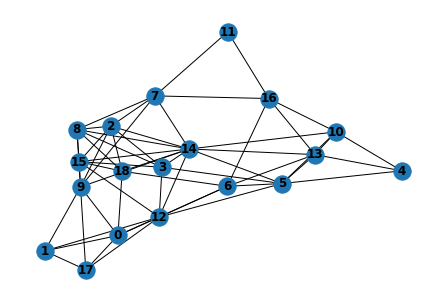

In [3]:
#extract the values from the node/edge sets
edges = edge_set.values
nodes = node_set.values

#empty graph that will be populated with the nodes/edges
graph = nx.Graph()

#add nodes to the graph
for i in range(len(nodes)):
    graph.add_node(nodes[i][2], name = nodes[i][1])
    
    #check the added nodes
    #print("Added node " + str(nodes[i][2]) + " with name " + str(nodes[i][1]))

#add edges to the graph
for i in range(len(edges)):
    graph.add_edge(edges[i][0], edges[i][1])
    
    #check the added edges
    #print("Added edge (" + str(edges[i][0]) + ", " + str(edges[i][1]) + ")")
    
#draw the graph
nx.draw(graph, with_labels=True, font_weight='bold')

## Cleaning up the graph
We see that certain nodes have many less connections in the graph, these nodes can be thought of as outliers (e.g. nodes: 4, 11). We can inspect the label associated with each node as follows:

In [4]:
#print the labels associated with the outliers
print(graph.nodes[4]['name'])
print(graph.nodes[11]['name'])

Foundations of Databases
Embedded Real-Time Control


In order to improve the predictive power of our schema, we might want to get rid of these outliers. To do so we need a way of sorting the nodes, based on node degree, and a criterion for deciding which nodes represent outliers. 

Let's first plot the degree distribution and compute the average degree of a node.

Average node degree: 6.0


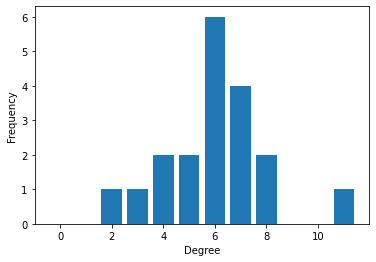

In [5]:
#plot the degree histogram
deg_hist = nx.degree_histogram(graph)
plt.bar(range(0, len(deg_hist)), deg_hist)
plt.ylabel('Frequency')
plt.xlabel('Degree');

#compute the average degree of a node
num_nodes = 0
avg_deg = 0
for i in range(len(deg_hist)):
    num_nodes += deg_hist[i]
    avg_deg += i*deg_hist[i]
avg_deg /= num_nodes
print("Average node degree: " + str(avg_deg))

We would like to remove the $n'$ nodes with the lowest degree, out of the $n$ total nodes. To compute $n'$ we define $\alpha = \frac{n'}{n}$.

The user will provide $\alpha$, the portion of nodes with lowest degree that should be removed, and $n'$ will be set to $n' = \lfloor \alpha n \rfloor$.

Let $S^{(i)}$ be the set of nodes in the graph that have degree $i$. Note that for some $k \in \mathbb{N}$ we might have $\sum_{i=0}^k |S^{(i)}| < n', \sum_{i=0}^{k+1} |S^{(i)}| > n'$. For example, we can see from the above histogram that there are 2 nodes with degree $\leq 3$ ($\sum_{i=0}^{3} |S^{(i)}| = 2$) and 4 nodes with degree $\leq 4$ ($\sum_{i=0}^{4} |S^{(i)}| = 4$). If we now wanted to eliminate the $n' = 3$ nodes with lowest degree from the graph, we would have to arbitraily choose one of the nodes with degree $4$.
We will avoid this choice by simply removing the nodes with degree $< k'$, where $$k' = \min\left\{k \in \mathbb{N}: \sum_{i=0}^k |S^{(i)}| > n'\right\}.$$

In [6]:
alpha = 0.2

#compute the degree threshold at which nodes will be maintained in the graph
degree_threshold = 0
num_nodes2remove = math.floor(alpha*nx.number_of_nodes(graph))
num_nodes_removed = 0
while num_nodes_removed + deg_hist[degree_threshold] <= num_nodes2remove:
    num_nodes_removed += deg_hist[degree_threshold]
    degree_threshold += 1
print("Degree threshold (nodes below this threshold will be removed): " + str(degree_threshold))
print(str(num_nodes_removed) + " nodes will be removed, ideally " + str(num_nodes2remove) + " nodes would be removed")

Degree threshold (nodes below this threshold will be removed): 4
2 nodes will be removed, ideally 3 nodes would be removed


Let's remove the nodes whose degree is below the threshold and plot the resulting graph.

Removed: {'name': 'Foundations of Databases'}
Removed: {'name': 'Embedded Real-Time Control'}


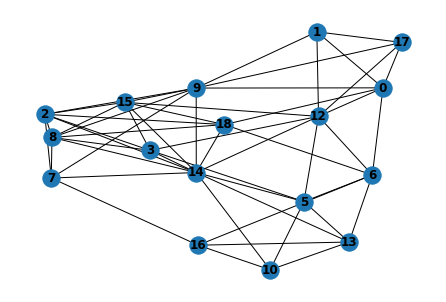

In [7]:
#remove the nodes that have degree below the threshold from the graph
for node in list(nx.nodes(graph)):
    if nx.degree(graph, node) < degree_threshold:
        #check the removed node
        print("Removed: " + str(graph.nodes[node]))
        graph.remove_node(node)
        
#plot the resulting graph
nx.draw(graph, with_labels=True, font_weight='bold')

## Identifying communities
We will now try and identify the communities in the graph by using two approaches.

We first try the Girvan-Newman algorithm, reporting the resulting dendrogram.

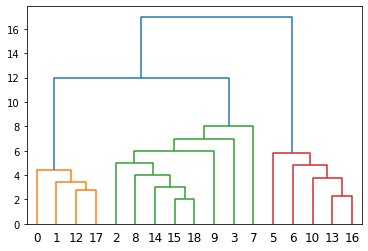

In [8]:
#detect communities based on the Girvan-Newman algorithm
gn_communities = ct.girvan_newman(graph)

#draw the associated dendrogram
gn_communities = list(gn_communities)
gn_communities_temp = copy.deepcopy(gn_communities)
draw_dendogram_girvan_newman_communities(gn_communities_temp)

Now we need to figure out where to cut the dendrogram to obtain the best partition possible. We do so by maximizing the Modularity score of the partition associated with the cut.

In [9]:
#compute the best graph partition
max_modularity = -1.0
partition_index = -1
for i in range(len(gn_communities)):
    if max_modularity < ct.quality.modularity(graph, gn_communities[i]):
        max_modularity = ct.quality.modularity(graph, gn_communities[i])
        partition_index = i
print("Maximum modularity: " + str(max_modularity) + "\nBest partition at depth: " + str(partition_index+1))

#partition with the best modularity score
gn_communities = gn_communities[partition_index]

Maximum modularity: 0.2893860946745562
Best partition at depth: 2


The communities associated with the best partition are:


Community 0, nodes: [0, 1, 12, 17], labels: 
-Automata, Languages and Computation
-Operations Research 1
-Advanced Algorithm Design
-Operations Research 2

Community 1, nodes: [2, 3, 7, 8, 9, 14, 15, 18], labels: 
-Machine Learning
-Inferential Statistics
-Computer Vision
-Deep Learning
-Artificial Intelligence
-Learning from Networks
-Reinforcement Learning
-Digital Circuits for Neural Networks

Community 2, nodes: [5, 6, 10, 13, 16], labels: 
-Big Data Computing
-Parallel Computing
-Web Applications
-Distributed Systems
-Concurrent and Real-Time Programming


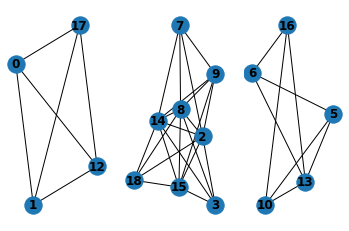

In [10]:
#print the communities and draw the associated subgraphs
report_communities(graph, gn_communities)

We can see that 3 communities were identified. Let's call them "Theoretical Computer Science", "Machine Learning/Artificial Intelligence" and "Computing Systems". 

Let's try another community detection algorithm, namely the greedy agglomerative modularity-based clustering method.


Community 0, nodes: [2, 3, 18, 7, 8, 14, 15], labels: 
-Machine Learning
-Inferential Statistics
-Digital Circuits for Neural Networks
-Computer Vision
-Deep Learning
-Learning from Networks
-Reinforcement Learning

Community 1, nodes: [16, 5, 6, 10, 13], labels: 
-Concurrent and Real-Time Programming
-Big Data Computing
-Parallel Computing
-Web Applications
-Distributed Systems

Community 2, nodes: [0, 1, 17, 9, 12], labels: 
-Automata, Languages and Computation
-Operations Research 1
-Operations Research 2
-Artificial Intelligence
-Advanced Algorithm Design


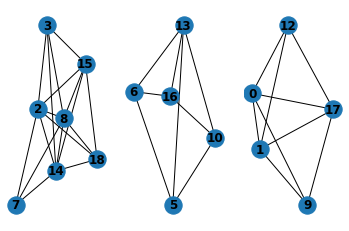

In [11]:
#detect communities based on greedy modularity
gm_communities = ct.greedy_modularity_communities(graph)

#print the communities and draw the associated subgraphs
report_communities(graph, gm_communities)

The detected communities are almost identical. The two presented approaches are somewhat similar and both of them use the Modularity. The first method is a top-down (divisive) approach based on Link-betweenness, that uses Modularity to determine the best partition. The second is instead a bottom-up (agglomerative) approach that uses Modularity to perform the greedy choice.

Up to now both of these methods seem to work similarly well, however, in order to perform community detection and classification we need to pick just one. We have chosen to continue from now on with the second method, since it takes care of determining the best partition automatically. Furthermore, in our tests, the schema based on the bottom-up approach was significantly faster.

## Real-world graphs
Let's now apply the presented framework to determine the communities in a real-world graph of our interest. 

In the above toy example the data was flawless. In datasets coming fom the real world we might have corrupted data. Nodes might be unlabeled and edges might have end-nodes that are not present in the graph. So, before applying the community detection procedure, we would like to remove these imperfections. This is going to be done by the function that imports the graph from the input files.

In [12]:
#import the graph of interest
graph = import_graph("data/fb-pages-government.nodes", "data/fb-pages-government.edges")

#remove outliers
graph = clean_up(graph, alpha = 0.2)

#detect communities based on greedy modularity
gm_communities = ct.greedy_modularity_communities(graph)

#print the communities and draw the associated subgraphs
#report_communities(graph, gm_communities)

Now that we have the detected communities we can inspect them to determine how well the procedure has worked.

In [13]:
#unfreeze the communities
gm_communities = list([list(x) for x in gm_communities])

#number of detected communities
num_communities = len(gm_communities)
print("Number of detected communities: " + str(num_communities))

#number of members of each community
num_members = list()
for i in range(num_communities):
    num_members.append(len(gm_communities[i]))
    print("Community " + str(i) + " has " + str(num_members[i]) + " members")
    
#the subgraph of each community
subgraphs = list()
for community_index in range(num_communities):
    subgraphs.append(nx.subgraph(graph, gm_communities[community_index]))
    
#list of labels for each community
labels = list()
for community_index in range(len(subgraphs)):
    community_labels = list()
    for node in list(nx.nodes(subgraphs[community_index])):
        community_labels.append(subgraphs[community_index].nodes[node]['name'])
        print("Node " + str(node) + " of community " + str(community_index) + " has label " + 
              subgraphs[community_index].nodes[node]['name'])
    labels.append(community_labels)

Number of detected communities: 18
Community 0 has 2235 members
Community 1 has 1319 members
Community 2 has 884 members
Community 3 has 484 members
Community 4 has 365 members
Community 5 has 58 members
Community 6 has 53 members
Community 7 has 39 members
Community 8 has 31 members
Community 9 has 24 members
Community 10 has 24 members
Community 11 has 19 members
Community 12 has 18 members
Community 13 has 16 members
Community 14 has 14 members
Community 15 has 12 members
Community 16 has 11 members
Community 17 has 4 members
Node 11 of community 0 has label NASA's Marshall Space Flight Center
Node 13 of community 0 has label 1st Armored Division Sustainment Brigade
Node 15 of community 0 has label Transportation Security Administration
Node 17 of community 0 has label US National Weather Service Morristown Tennessee
Node 18 of community 0 has label Fort Worth Police Department
Node 19 of community 0 has label National Institute of General Medical Sciences
Node 22 of community 0 has

In the end we obtain a list of labels, where each label can be accessed by **lables[community_index][member_index]**, and a list of sugraphs, where each subgraph can be accessed by **subgraphs[community_index]**. 

Let's now take a look at one of the detected communities.

- node: 224 label: Justis- og beredskapsdepartementet
- node: 4358 label: Statsministerens kontor (Norge)
- node: 2728 label: Kommunal- og moderniseringsdepartementet (Norge)
- node: 1960 label: Barne- og likestillingsdepartementet (Norge)
- node: 1994 label: Olje- og energidepartementet (Norge)
- node: 1369 label: Arbeids- og sosialdepartementet (Norge)
- node: 3117 label: Krisinformation.se
- node: 4660 label: Finansdepartementet (Norge)
- node: 7031 label: Kulturdepartementet
- node: 7001 label: Utenriksdepartementet (Norge)
- node: 6972 label: Nærings- og fiskeridepartementet (Norge)
- node: 5214 label: Kunnskapsdepartementet (Norge)


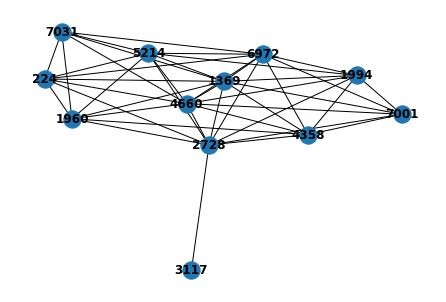

In [14]:
#the 16th community
nx.draw(subgraphs[15], with_labels=True, font_weight='bold')
for node in nx.nodes(subgraphs[15]):
    print("- node: " + str(node) + " label: " + str(subgraphs[15].nodes[node]['name']))

We see the presence of an outlier (node 3117), thus, before proceeding with community classification, we might want to remove the outliers. This can be done as follows:

- node: 224 label: Justis- og beredskapsdepartementet
- node: 4358 label: Statsministerens kontor (Norge)
- node: 2728 label: Kommunal- og moderniseringsdepartementet (Norge)
- node: 1960 label: Barne- og likestillingsdepartementet (Norge)
- node: 1994 label: Olje- og energidepartementet (Norge)
- node: 1369 label: Arbeids- og sosialdepartementet (Norge)
- node: 4660 label: Finansdepartementet (Norge)
- node: 7031 label: Kulturdepartementet
- node: 7001 label: Utenriksdepartementet (Norge)
- node: 6972 label: Nærings- og fiskeridepartementet (Norge)
- node: 5214 label: Kunnskapsdepartementet (Norge)


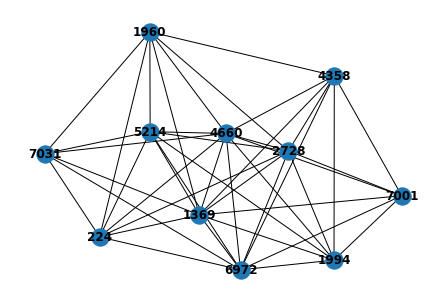

In [15]:
#remove the outliers
subgraphs[15] = clean_up(subgraphs[15], alpha = 0.2)

#update the community labels
labels[15] = extract_labels(subgraphs[15])

#community after outrlier removal
nx.draw(subgraphs[15], with_labels=True, font_weight='bold')
for node in nx.nodes(subgraphs[15]):
    print("- node: " + str(node) + " label: " + str(subgraphs[15].nodes[node]['name']))

Note that we need to explicitly update the list of labels by calling the appropriate function (i.e. extract_labels()).

By inspecting the communities we see a pattern. Each community seems to be associated with a geographic area, a culture and/or a language. We conclude then that the highest-level information contained in the graph is related to these factors. 

Some communities are very small (e.g. the 16th community associated with norwegian institutions) while others are huge (e.g. the 1st community associated with general western institutions). We might want to break down these communities further. We can do so by applying the community detection algorithm to the subgraphs that are associated with them. However, we might end up with sub-communities that are not partitioned according to the same criteria used for the original communities.

Let's further divide the first community into sub-communities as an example.

In [16]:
#copy the first community so we do not modify the original partition
sub_community = copy.deepcopy(subgraphs[0])

#clean up the outliers
sub_community = clean_up(sub_community, alpha = 0.2)

#results of community detection
sub_subgraphs = detect_communities(sub_community)

#extract the community labels
labels = list()
for community_graph in sub_subgraphs:
    labels.append(extract_labels(community_graph))

#print the labels
for community_index in range(len(labels)):
    for member_index in range(len(labels[community_index])):
        print("Member " + str(member_index) + " of community " + str(community_index) + " has label " + 
              labels[community_index][member_index])

Number of detected communities: 5
Community 0 has 881 members
Community 1 has 742 members
Community 2 has 99 members
Community 3 has 59 members
Community 4 has 9 members
Member 0 of community 0 has label National Tsunami Warning Center
Member 1 of community 0 has label NASA Explores
Member 2 of community 0 has label NOAA Marine Debris
Member 3 of community 0 has label Columbus Division of Police
Member 4 of community 0 has label GOES-R (Geostationary Operational Environmental Satellite - R Series)
Member 5 of community 0 has label NASA's Marshall Space Flight Center
Member 6 of community 0 has label Alameda County District Attorney's Office
Member 7 of community 0 has label Fairfax County Police Department
Member 8 of community 0 has label The National Institute on Drug Abuse - NIDA
Member 9 of community 0 has label US National Weather Service Morristown Tennessee
Member 10 of community 0 has label Fort Worth Police Department
Member 11 of community 0 has label Pacific Southwest Region

We once agin see that the detected communities are mostly associated to the same geographic area, culture and/or language. Thus, in this case, the sub-communities are partitioned according to the same criteria as the initial community. This suggests that the main information that we can infere from this graph, that is also the main reason for the graph topology, is related to geography, language and culture.

Let's try and detect the communities in another real-world graph.

In [17]:
#import the graph of interest
graph = import_graph("data/fb-pages-politician.nodes", "data/fb-pages-politician.edges")

#remove outliers from the whole graph
graph = clean_up(graph, alpha = 0.2)

#detect the communities and return the associated subgraphs
community_subgraphs = detect_communities(graph)

#remove the outliers of each community
for community_index in range(len(community_subgraphs)):
    community_subgraphs[community_index] = clean_up(community_subgraphs[community_index], alpha = 0.2)

#extract the community labels
labels = list()
for community_graph in community_subgraphs:
    labels.append(extract_labels(community_graph))

#print the labels
for community_index in range(len(labels)):
    for member_index in range(len(labels[community_index])):
        print("Member " + str(member_index) + " of community " + str(community_index) + " has label " + 
              labels[community_index][member_index])

Number of detected communities: 32
Community 0 has 1453 members
Community 1 has 984 members
Community 2 has 504 members
Community 3 has 419 members
Community 4 has 402 members
Community 5 has 354 members
Community 6 has 314 members
Community 7 has 229 members
Community 8 has 166 members
Community 9 has 130 members
Community 10 has 84 members
Community 11 has 55 members
Community 12 has 32 members
Community 13 has 18 members
Community 14 has 17 members
Community 15 has 16 members
Community 16 has 12 members
Community 17 has 11 members
Community 18 has 9 members
Community 19 has 9 members
Community 20 has 9 members
Community 21 has 8 members
Community 22 has 8 members
Community 23 has 7 members
Community 24 has 7 members
Community 25 has 7 members
Community 26 has 6 members
Community 27 has 6 members
Community 28 has 5 members
Community 29 has 5 members
Community 30 has 3 members
Community 31 has 3 members
Member 0 of community 0 has label Monika Grütters
Member 1 of community 0 has labe

In this case it is quite difficult to understand what makes members of the same community "similar".

# Graph classification

In this part we will create the LabeledGraph class a modification of the code above in order to label the graph of the two datasets.

An instance of the LabeledGraph class contains labels and labeled_graph:
- labels: it contains a dictionary with the correspondance Language <-> Id
- labeled_graph: the graph in which each node has three features (name, language and language_id)

In [18]:
from iso639 import Lang
from iso639.exceptions import InvalidLanguageValue
from langdetect import detect
import pycld2 as cld2

class LabeledGraph:
    def __init__(self, edges, nodes):
        self.labels = self.create_labels(nodes)
        self.labeled_graph = self.label_graph(nodes, edges, self.labels)
        
    #build the dictionary "labels" in which the key is the name of the language and the value is the id
    def create_labels(self, nodes): 
        label_set = set()
        all_labels = dict()
        id_lang = 0
        for i in range(len(nodes)):
            page_name = nodes[i][1]
            #detectiong the language of the name of the page
            isReliable, _, details = cld2.detect(page_name)
            if isReliable:
                for lang in details:
                    code = lang[1]
                    if code != 'un':
                        try:
                            # see if the language is classified inside a macrolanguage (we consider the macrolanguage)
                            if Lang(code).macro() == None:
                                label_set.add(Lang(code)[0])
                            else:
                                label_set.add(Lang(code).macro()[0])
                            #there are outputs {'zh-tw', 'zzp', 'iw', 'jw', 'zh-Hant', 'un', 'zh-cn'}
                            #of the detection functions that are not read by the Lang() function
                        except InvalidLanguageValue as e:
                            if code.find('zh') != -1:
                                label_set.add(Lang('zh')[0])
                            else:
                                label_set.add('Not detected')

            else:
                predicted_language = detect(page_name)
                #use the other method
                if predicted_language.find('zh') != -1:
                    # substitute every occurence of "zh-..." with simply zh
                    label_set.add(Lang('zh')[0])

                else:
                    label_set.add(Lang(predicted_language)[0])

        # build the dictionary
        for label in label_set:
            all_labels[label] = id_lang
            id_lang += 1
            
        return all_labels
    
    def label_graph(self, nodes, edges, all_labels):
        graph = nx.Graph()
        
        #add nodes to the graph
        for i in range(len(nodes)):
            page_name = nodes[i][1]
            #detectiong the language of the name of the page
            isReliable, _, details = cld2.detect(page_name)
            #list of all the languages detected (there can be up to 3 languages)
            cod = list()
            if isReliable:
                for lang in details:
                    if lang[1] != 'un':
                        if lang[1].find('zh') != -1:
                            # substitute every occurence of "zh-..." with simply zh
                            cod.append('zh')
                        else:
                            cod.append(lang[1])
            else:
                predicted_language = detect(page_name)
                #use the other method
                if predicted_language.find('zh') != -1:
                    # substitute every occurence of "zh-..." with simply zh
                    cod.append('zh')

                else:
                    cod.append(predicted_language)

            languages = list()
            languages_id = list()
            for lang in cod:
                try:
                    # if the language is classified inside a macrolanguage (we consider the macrolanguage)
                    if Lang(lang).macro() == None:
                        if Lang(lang)[0] in all_labels:
                            languages.append(Lang(lang)[0])
                            languages_id.append(all_labels[Lang(lang)[0]])
                        else:
                            languages.append('Not detected')
                            languages_id.append(all_labels['Not detected'])
                    else:
                        if Lang(lang).macro()[0] in all_labels:
                            languages.append(Lang(lang).macro()[0])
                            languages_id.append( all_labels[Lang(lang).macro()[0]])
                        else:
                            languages.append('Not detected')
                            languages_id.append(all_labels['Not detected'])
                    #there are outputs {'zh-tw', 'zzp', 'iw', 'jw', 'zh-Hant', 'un', 'zh-cn'}
                    #of the detection functions that are not read by the Lang() function
                    # so we consider them as "Not detected"
                except InvalidLanguageValue as e:
                    if lang.find('zh') != -1:
                        languages.append(Lang('zh')[0])
                        languages_id.append(all_labels[Lang('zh')[0]] )
                    else:
                        languages.append('Not detected')
                        languages_id.append(all_labels['Not detected'])

            graph.add_node(nodes[i][2], name = page_name, languages = languages, languages_id = languages_id)


        #add edges to the graph
        for i in range(len(edges)):
            graph.add_edge(edges[i][0], edges[i][1])
            
        #draw the graph
        nx.draw(graph, with_labels=True, font_weight='bold')
        return graph

In [19]:
#edge_filename = "data/fb-pages-government.edges"
#node_filename = "data/fb-pages-government.nodes"

# uncomment and repeat the procedure for this dataset
edge_filename = "data/fb-pages-politician.edges"
node_filename = "data/fb-pages-politician.nodes"

#read the datasets
edge_set = pd.read_csv(edge_filename, sep = ',')
node_set = pd.read_csv(node_filename, sep = ',')

#print the datasets
print(edge_set)
print(node_set)

          0  1972
0         0  5111
1         0   138
2         0  3053
3         0  1473
4         0  4978
...     ...   ...
41723  5871  5873
41724  5879  5888
41725  5882  5899
41726  5882  5898
41727  5886  2981

[41728 rows x 2 columns]
                   id              name  new_id
0     127397457601670               陳根德    1661
1     169014523134260               林淑芬      52
2     295363753921281       Chris White    3477
3     613631835423903  Stewart Hosie MP    3193
4     284882801581896   Frank Schäffler    4425
...               ...               ...     ...
5903  342943772496246       Kevin Byrne    3778
5904  193944157325672      Timur Husein     439
5905     142026376065     Jeremy Lefroy     159
5906  294019144024664   Ileana Argentin     107
5907     142338164826     Rafael Anchía     390

[5908 rows x 3 columns]


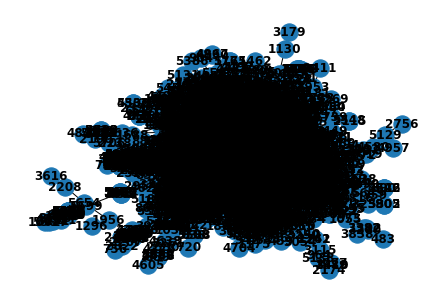

In [20]:
edges = edge_set.values
nodes = node_set.values
dataset = LabeledGraph(edges, nodes)

We can now remove the $n'$ nodes with the lowest degree, out of the $n$ total nodes. To compute $n'$ we define $\alpha = \frac{n'}{n}$. The user will provide $\alpha$, the portion of nodes with lowest degree that will be removed.

Average node degree: 14.125930941096819
Degree threshold (nodes below this threshold will be removed): 1
0 nodes will be removed, ideally 590 nodes would be removed


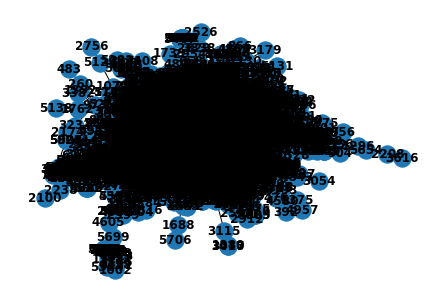

In [21]:
#compute the average degree of a node
deg_hist = nx.degree_histogram(dataset.labeled_graph)
num_nodes = 0
avg_deg = 0
for i in range(len(deg_hist)):
    num_nodes += deg_hist[i]
    avg_deg += i*deg_hist[i]
avg_deg /= num_nodes
print("Average node degree: " + str(avg_deg))

alpha = 0.1

#compute the degree threshold at which nodes will be maintained in the graph
degree_threshold = 0
num_nodes2remove = math.floor(alpha*num_nodes)
num_nodes_removed = 0
while num_nodes_removed + deg_hist[degree_threshold] <= num_nodes2remove:
    num_nodes_removed += deg_hist[degree_threshold]
    degree_threshold += 1
print("Degree threshold (nodes below this threshold will be removed): " + str(degree_threshold))
print(str(num_nodes_removed) + " nodes will be removed, ideally " + str(num_nodes2remove) + " nodes would be removed")

# Let's remove the nodes whose degree is below the threshold and plot the resulting graph.
for i in range(dataset.labeled_graph.number_of_nodes()):
    if dataset.labeled_graph.degree[i] < degree_threshold:
        #check the removed node
        print("Removed: " + str(dataset.labeled_graph.nodes[i]))
        dataset.labeled_graph.remove_node(i)
        
nx.draw(dataset.labeled_graph, with_labels=True, font_weight='bold')

Let's use the greedy modularity algorithm to get the communities

In [22]:
#detect communities based on greedy modularity
gm_communities = ct.greedy_modularity_communities(dataset.labeled_graph)

Now we have to assign the true value $y_i$ (that is the most frequent language of the pages of the community $i$) to each subgraph (community). The value $y_i$ is assigned as an attribute of the (sub)graph.

Then we create the tensor x_list of the node feature matrix with shape [num_nodes, num_node_features] that we will need for the GCN model

In [23]:
import pycld2 as cld2
from langdetect import detect
import torch

def most_frequent(List):
    return max(set(List), key = List.count)

communities = list([list(x) for x in gm_communities])
main_languages = list()
x_list = list()
for i in range(len(communities)):
    community_languages = list()
    x_list_i = list()
    for j in range(len(communities[i])):
        if any(dataset.labeled_graph.nodes[communities[i][j]]):
            for language in dataset.labeled_graph.nodes[communities[i][j]]['languages']:
                community_languages.append(language)
            x_list_i.append([dataset.labeled_graph.nodes[communities[i][j]]['languages_id'][0]])
    main_languages.append(most_frequent(community_languages))
    x = torch.tensor(x_list_i, dtype = torch.float32)
    x_list.append(x)

We now create a proper sub-graph (not a copy view of the original one) for each of the community

Note: I did it this way because I thought this was the problem that caused the failure in the training of the model: I thought the problem was that the model was still seeing the data of the nodes in the original graph, that should be the case if we use networkx.subgraph function (see the Pytorch Geometric documentation)

In [24]:
#create a list of the sub-graphs (communities)
list_communities = list()
for i in range(len(communities)):
    graph_temp = nx.Graph()
    subgraph_dict = nx.subgraph(dataset.labeled_graph, communities[i]).nodes.data(True)
    for elem in subgraph_dict:
        if any(elem[1]):
            node = elem[0]
            print(elem[1])
            page_name = elem[1]['name']
            languages = elem[1]['languages']
            languages_id = elem[1]['languages_id']
            graph_temp.add_node(node, name = page_name, languages = languages, languages_id = languages_id)
    graph_temp.graph['main_language'] = dataset.labels[main_languages[i]]
    egde_sub = list(nx.subgraph(dataset.labeled_graph, communities[i]).edges)
    for e in egde_sub:
        graph_temp.add_edge(e[0], e[1])
    
    list_communities.append(graph_temp)

{'name': 'Françoise Guégot', 'languages': ['French'], 'languages_id': [62]}
{'name': 'Monika Grütters', 'languages': ['English'], 'languages_id': [48]}
{'name': 'Lance Gooden', 'languages': ['French'], 'languages_id': [62]}
{'name': 'Ivan ŠTEFANEC', 'languages': ['Slovenian'], 'languages_id': [88]}
{'name': 'François Hollande', 'languages': ['English'], 'languages_id': [48]}
{'name': 'Dariusz Rosati', 'languages': ['Polish'], 'languages_id': [53]}
{'name': 'Marie-Pierre De la Gontrie', 'languages': ['French'], 'languages_id': [62]}
{'name': 'Elmar Brok', 'languages': ['Swedish'], 'languages_id': [72]}
{'name': 'Andrew J. Ullmann', 'languages': ['Swedish'], 'languages_id': [72]}
{'name': 'Benjamin Strasser', 'languages': ['German'], 'languages_id': [94]}
{'name': 'Fernando Ruas', 'languages': ['Interlingua (International Auxiliary Language Association)'], 'languages_id': [102]}
{'name': 'Claudette Buttigieg', 'languages': ['English'], 'languages_id': [48]}
{'name': 'Bronisław Komorowski

Now let's organize the data as an instance of the torch_geometric.data.Data class

In [25]:
from torch_geometric.data import Data

def get_edge_index_tensor(community):
    sub_edges = list(community.edges)
    arr = np.transpose(np.array(sub_edges))
    arr = torch.tensor(arr, dtype=torch.int64)
    return arr


train_set = list()
for i in range(10):
    x = x_list[5+i]
    y = torch.tensor(list_communities[5+i].graph['main_language'], dtype=torch.float32)
    edge_index = get_edge_index_tensor(list_communities[5+i])
    data_train_i = Data(x=x, y=y, edge_index=edge_index)
    train_set.append(data_train_i)

In the end let's define a model for the classification of the communities using Graph Convolutional Network layers

In [26]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

# the only feature we have is the language of the page
num_node_features = 1
# the classes are the language appeared in the graph
num_classes = len(dataset.labels)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=110, bias=True)
)


In [27]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_set: 
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader: 
         out = model(data.x)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

RuntimeError: index 5111 is out of bounds for dimension 0 with size 398